In [1]:
%matplotlib inline

import GPy
from GPy.plotting.matplot_dep.util import fixed_inputs
from chained_gp.svgp_multi import SVGPMulti
from chained_gp.het_beta import HetBeta
from chained_gp.svgp_beta import SVGPBeta

import numpy as np

import scipy as sp
from scipy.stats import beta as beta_dist
from scipy import io

import pods
import pandas as pd

import pylab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import num2date
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
from matplotlib.dates import date2num
from matplotlib import rc
from matplotlib2tikz import save as tikz_save

import climin
import sys
from functools import partial

pylab.rcParams['figure.figsize'] = 10, 8  # that's default image size for this 
np.random.seed(0)

Due to Twitters restrictions on data sharing, data has to be downloaded using the twitter API. Please change your pods config file to include a twitter API key and secret. 

pods will then download a list of files with twitter ids and derived sentiment. Finally using the twitter API times of these tweets will be found. Unfortunately due to API restriction this will take a number of hours (approximately 6).

Since the API only allows non-deleted tweets to be downloaded, the dataset may differ slightly from that used in the original paper, but due to such a large dataset, differences should be minimal.

In [2]:
import time
now = time.time()
politics_dict = pods.datasets.politics_twitter()
download_time = time.time() - now
print download_time

Data already scraped, loading saved scraped data for ukip party
Data already scraped, loading saved scraped data for labour party
Data already scraped, loading saved scraped data for conservative party
Data already scraped, loading saved scraped data for greens party
0.252290964127


In [3]:
ukip_df = politics_dict['ukip'].reset_index(drop=True)
greens_df = politics_dict['greens'].reset_index(drop=True)
conservative_df = politics_dict['conservative'].reset_index(drop=True)
labour_df = politics_dict['labour'].reset_index(drop=True)

In [4]:
#Merge all the dataframes
ukip_df['party'] = 'ukip'
greens_df['party'] = 'greens'
conservative_df['party'] = 'conservative'
labour_df['party'] = 'labour'

ukip_df['color'] = 'm'
greens_df['color'] = 'g'
conservative_df['color'] = 'b'
labour_df['color'] = 'r'

tweets_df = pd.concat([ukip_df, greens_df, conservative_df, labour_df])

In [5]:
tweets_df[tweets_df['party'] == 'ukip'].reset_index().describe()

,index,Unnamed: 0,id_str,pos,neg
count,119426.000000,119426.000000,1.194260e+05,119118.000000,119118.000000
mean,59712.500000,72021.940130,-6.344811e+13,0.532757,0.467243
std,34475.460961,41621.815613,5.636810e+14,0.136811,0.136811
min,0.000000,0.000000,5.947405e+17,0.001071,0.000174
25%,29856.250000,35954.250000,5.956316e+17,0.459213,0.403904
50%,59712.500000,72000.500000,5.961970e+17,0.538493,0.461507
75%,89568.750000,108096.750000,5.964421e+17,0.596096,0.540787
max,119425.000000,144120.000000,5.968269e+17,0.999826,0.998929


Remove all that are exactly 50/50 as these come from not being able to find any useful words

In [6]:

tweets_df.ix[tweets_df['pos'] == 0.5, 'pos'] = np.nan
tweets_df.dropna(subset=['pos'], inplace=True)
tweets_df['time'] = pd.to_datetime(tweets_df['time'])
#Make timestamp from time object
tweets_df['timestamp'] = tweets_df['time'].apply(date2num)
parties_df = tweets_df.groupby('party')

In [7]:
parties = tweets_df['party'].unique()
num_parties = parties.shape[0]

In [8]:
labour_df.describe()

,Unnamed: 0,id_str,pos,neg
count,90071.000000,9.007100e+04,90071.000000,90071.000000
mean,52677.405047,-8.600427e+13,0.530700,0.469300
std,30445.046677,7.142888e+14,0.140796,0.140796
min,1.000000,5.941687e+17,0.001071,0.000174
25%,26295.500000,5.952944e+17,0.452578,0.405021
50%,52670.000000,5.961773e+17,0.535739,0.464261
75%,79027.000000,5.964722e+17,0.594979,0.547422
max,105395.000000,5.968268e+17,0.999826,0.998929


In [9]:
tweets_df[tweets_df['party'] == 'ukip']['time'].describe()

count                  119118
unique                  97924
top       2015-05-07 09:20:17
freq                       38
first     2015-05-03 05:49:21
last      2015-05-08 23:59:56
Name: time, dtype: object

In [10]:
tweets_df[tweets_df['party'] == 'labour']['time'].describe()

count                   90071
unique                  78661
top       2015-05-08 11:17:56
freq                        9
first     2015-05-01 15:57:15
last      2015-05-08 23:59:38
Name: time, dtype: object

Plot a simple look at how the sentiment varies through time

conservative
greens
labour
ukip


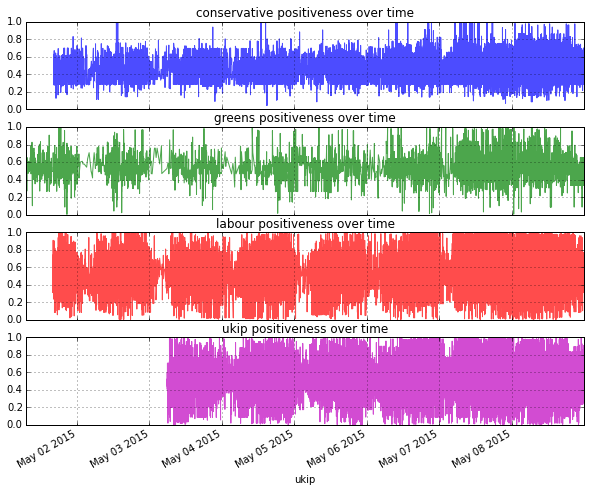

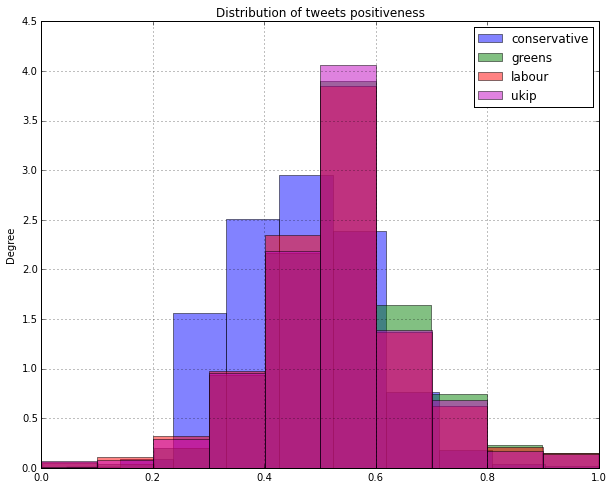

In [11]:
fig, axes = plt.subplots(len(parties), 1, sharex=True)
fig_hist, hist_ax = plt.subplots(1,1)
for (party, party_df), ax in zip(parties_df, axes):
    print party
    color = party_df['color'][0]
    
    party_df['pos'].plot(kind='hist', alpha=0.49, normed=True, label=party, ax=hist_ax, color=color)
    plt.title("Distribution of tweets positiveness")

    ax.set_title("{} positiveness over time".format(party))
    party_df.plot(x='time', y='pos', ax=ax, c=color, label=party, legend=False, alpha=0.7)
    ax.set_ylim(0,1)
    ax.set_xlim(tweets_df['timestamp'].min(), tweets_df['timestamp'].max())
plt.legend()


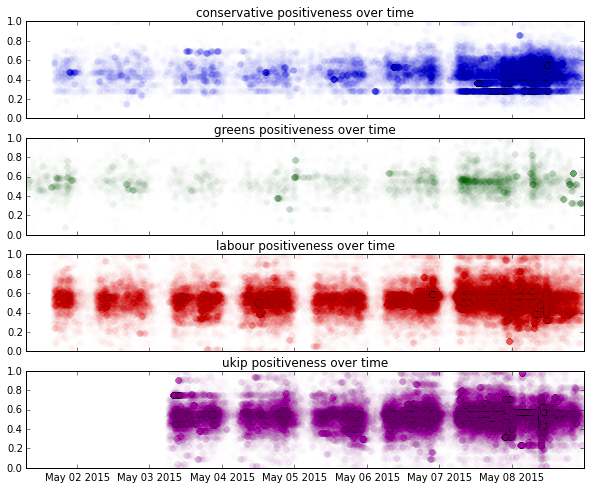

In [12]:
fig, axes = plt.subplots(len(parties), 1, sharex=True)
for (party, party_df), ax in zip(parties_df, axes):
    color = party_df['color'][0]
    ax.set_title("{} positiveness over time".format(party))
    ax.plot_date(party_df['timestamp'], party_df['pos'], 'o', color=color, alpha=0.01, lw=0)

They are very centred, so we can transform them to see some more interesting shapes in our beta distribution, like reweighting exam scores

In [13]:
#Sort based on 'pos' with all parties together
transformed_tweets = tweets_df.sort(columns='pos')

#draw N random uniform 'pos' values
#replace each pos value with its corresponding (index) random value
transformed_tweets['pos'] = np.sort(np.random.uniform(0, 1, transformed_tweets.shape[0]))

transformed_grouped = transformed_tweets.groupby('party')

conservative
greens
labour
ukip


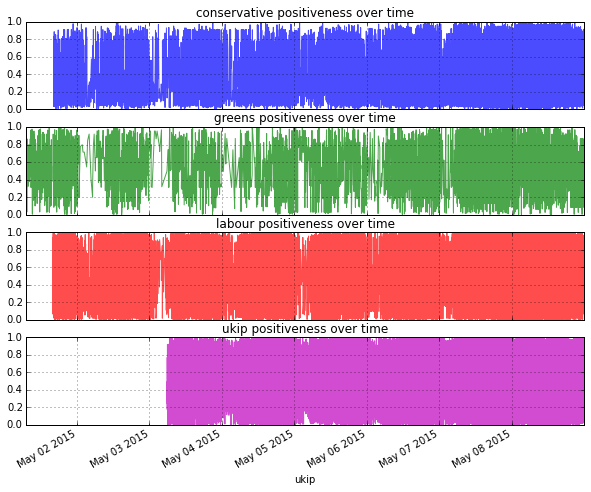

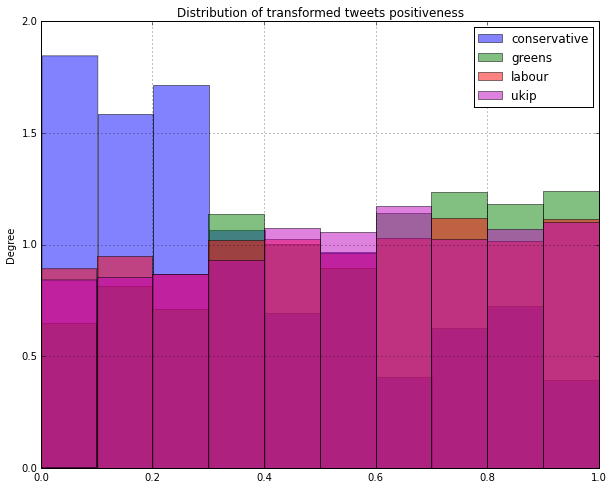

In [14]:
fig, axes = plt.subplots(len(parties), 1, sharex=True)
fig_hist, hist_ax = plt.subplots(1,1)
for (party, party_df), ax in zip(transformed_grouped, axes):
    print party
    color = party_df['color'][0]
    
    party_df['pos'].plot(kind='hist', alpha=0.49, normed=True, label=party, ax=hist_ax, color=color)
    plt.title("Distribution of transformed tweets positiveness")

    ax.set_title("{} positiveness over time".format(party))
    party_df.plot(x='time', y='pos', ax=ax, c=color, label=party, legend=False, alpha=0.7)
    ax.set_ylim(0,1)
    ax.set_xlim(tweets_df['timestamp'].min(), tweets_df['timestamp'].max())
plt.legend()


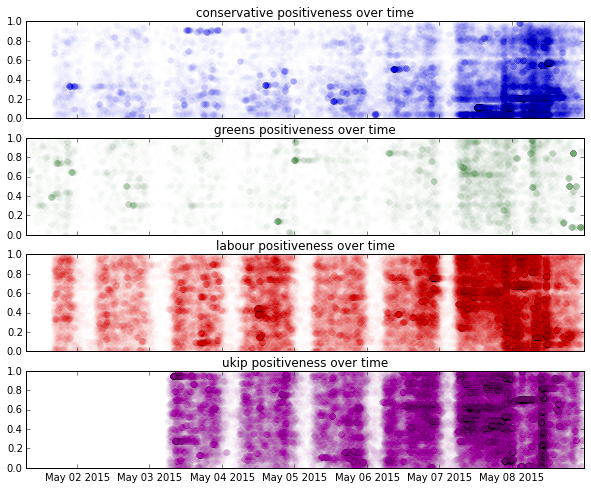

In [15]:
fig, axes = plt.subplots(len(parties), 1, sharex=True)
for (party, party_df), ax in zip(transformed_grouped, axes):
    color = party_df['color'][0]
    ax.set_title("{} positiveness over time".format(party))
    ax.plot_date(party_df['timestamp'], party_df['pos'], 'o', color=color, alpha=0.01, lw=0)

## Lets fit a chained gp

Lets fit a GP to it, with a beta likelihood and latent functions over log of both parameters!

In [16]:
party = 'labour'
party_df = parties_df.get_group(party)
#party_df = transformed_grouped.get_group(party)  # The reweighted will produce more extreme effects
party_df = party_df.sort(columns='pos')
party_df = party_df.reindex(np.random.permutation(party_df.index))
color = party_df['color'][0]

In [17]:
#subsample = 5000
#if subsample is not None:
    #df = df.loc[np.random.choice(df.index, subsample, replace=False)]

In [18]:
X = party_df['timestamp'][:, None]
X_offset = X.mean()
X_scale = X.max() - X.min()
X = (X - X_offset)/X_scale
Z = np.linspace(X.min(), X.max(), 100)[:, None]
Y = party_df['pos'][:, None]

Make data in GPy form

In [19]:
likelihood = HetBeta()

kernf = GPy.kern.Matern32(1, lengthscale=0.3, name='kernf_rbf1')
kernf += GPy.kern.White(1, variance=1e-5, name='f_white')
#kernf += GPy.kern.RBF(1, lengthscale=0.6, name='kernf_rbf2')
#Needs white or variance doesn't checkgrad!
kerng = GPy.kern.Matern32(1, lengthscale=0.3, name='kerng_rbf1')
kerng += GPy.kern.White(1, variance=1e-5, name='g_white')
#kerng += GPy.kern.RBF(1, lengthscale=0.6, name='kerng_rbf2')
kernf.name = 'kernf'
kerng.name = 'kerng'

kern = [kernf, kerng]

m = SVGPBeta(X, Y, Z, kern, likelihood, batchsize=500)

m.kernf.f_white.fix()
m.kerng.g_white.fix()
m.kernf.fix()
m.kerng.fix()
m.Z.fix()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [20]:

opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.1)
#opt = climin.RmsProp(m.optimizer_array, m.stochastic_grad, step_rate=0.04)

def callback(i, max_iter=5000):
    ll = m.log_likelihood()
    print str(i['n_iter']) + " " + str(ll) + " " + str(np.max(i['gradient'])), "\r",
    if np.isnan(ll):
        raise ValueError('Log likelihood went to nan')
    #Stop after max_iter iterations
    if i['n_iter'] > max_iter:
        return True
    return False

c_init = partial(callback, max_iter=1000)
info = opt.minimize_until(c_init)

# First 
m.kernf.constrain_positive()
m.kerng.constrain_positive()
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.03)
c_full = partial(callback, max_iter=500)
info = opt.minimize_until(c_full)

In [21]:
# Very simple annealing of step_rate
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.01)
c_full = partial(callback, max_iter=100)
info = opt.minimize_until(c_full)
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.001)
c_full = partial(callback, max_iter=100)
info = opt.minimize_until(c_full)
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.0001)
c_full = partial(callback, max_iter=100)
info = opt.minimize_until(c_full)

Since the plotting is very specific to the model (beta plot of politics) we will monkey patch a plotting function on

In [22]:

def plot_fs(self, dim=0, variances=False, median=True, true_variance=True,
                y_alpha=0.3, cmap=plt.cm.YlOrRd, num_pred_points=200,
                X_scale=1.0, X_offset=0.0, plot_dates=True, subsample=True):
    """
    Plotting for models with two latent functions, one is an exponent over the scale
    parameter
    """
    assert self.likelihood.request_num_latent_functions(self.Y) == 2
    if median:
        XX = fixed_inputs(self, non_fixed_inputs=[dim], fix_routine='median', as_list=False, X_all=True)
    else:
        XX = fixed_inputs(self, non_fixed_inputs=[dim], fix_routine='mean', as_list=False, X_all=True)
    #Now we have the other values fixed, remake the matrix to be the right shape
    XX = np.zeros((num_pred_points, self.X_all.shape[1]))
    for d in range(self.X_all.shape[1]):
        XX[:, d] = self.X_all[0, d]
    X_pred_points = XX.copy()
    X_pred_points_lin = np.linspace(self.X_all[:, dim].min(), self.X_all[:, dim].max(), XX.shape[0])
    X_pred_points[:, dim] = X_pred_points_lin

    mf, covf = self._raw_predict(X_pred_points, 0, full_cov=True)
    mg, covg = self._raw_predict(X_pred_points, 1, full_cov=True)

    covf = covf[:,:,0]
    covg = covg[:,:,0]

    num_samples = 60
    samples_f = np.random.multivariate_normal(mf.flatten(), covf, num_samples)
    samples_g = np.random.multivariate_normal(mg.flatten(), covg, num_samples)

    alpha = np.exp(samples_f)
    beta = np.exp(samples_g)

    num_y_pixels = 60
    #Want the top left pixel to be evaluated at 1
    line = np.linspace(1, 0, num_y_pixels)
    res = np.zeros((X_pred_points.shape[0], num_y_pixels))
    for j in range(X_pred_points.shape[0]):
        sf = alpha[:, j]  # Pick out the jth point along X axis
        sg = beta[:, j]
        for i in range(num_samples):
            # Pick out the sample and evaluate the pdf on a line between 0
            # and 1 with these alpha and beta values
            res[j, :] += beta_dist.pdf(line, sf[i], sg[i])
        res[j, :] /= num_samples

    vmax, vmin = res[np.isfinite(res)].max(), res[np.isfinite(res)].min()
    

    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
    
    X_all = self.X_all*X_scale + X_offset
    X_pred_points = X_pred_points*X_scale + X_offset
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)
    ax1.set_title('averaged pdf and data')
    im = ax1.imshow(res.T, origin='upper', 
                    extent=[X_pred_points[:,dim].min(),X_pred_points[:,dim].max(), 0, 1],
                    aspect='auto', cmap=cmap, norm=norm)
    fig.colorbar(im, orientation='horizontal', pad=0.2)
    #Subsample and change y_alpha accordingly
    subsample_inds = np.random.permutation(range(X_all.shape[0]))[:int(X_all.shape[0]*subsample)]
    X_sub = X_all[subsample_inds, :]
    Y_sub = self.Y_all[subsample_inds, :]
    y_alpha = y_alpha/float(subsample)
    if plot_dates:
        #All others should follow suit since we sharex
        ax1.plot_date(X_sub, Y_sub, 'kx', alpha=y_alpha)
    else:
        ax1.plot(X_sub, Y_sub, 'kx', alpha=y_alpha)

    #For labels
    ax2.set_title('Posterior GP for Beta distributed variables')
    ax2.plot(X_pred_points, beta.T[:,0], 'b-', label='beta', alpha=3./num_samples)
    ax2.plot(X_pred_points, alpha.T[:,0], 'm-', label='alpha', alpha=3./num_samples)
    
    #For rest of samples
    ax2.plot(X_pred_points, beta.T[:,1:], 'b-', alpha=3./num_samples)
    ax2.plot(X_pred_points, alpha.T[:,1:], 'm-', alpha=3./num_samples)
    ax2.legend()
    
    ax3.plot(X_pred_points, alpha.T / (alpha.T + beta.T), 'b-', alpha=3./num_samples)
    ax3.set_title('Mean')

    var = (alpha.T*beta.T) / ((alpha.T + beta.T)**2 * (alpha.T+beta.T +1))
    ax4.plot(X_pred_points, var, 'b-', alpha=3./num_samples)
    ax4.set_title('variance')

    for i in range(num_samples):
        a = alpha[i, :]
        b = beta[i, :]
        mode = (a - 1) / (a + b - 2)
        mode = np.where(mode < 0, np.nan, mode)
        ax5.plot(X_pred_points, mode, 'b-', alpha=3./num_samples)
    ax5.set_title('Modes where they exist (alpha > 1, beta > 1)')
    ax5.set_ylim(0,1)
    plt.legend()

    ax1.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())

    fig3d = plt.figure(figsize=(13,5))
    ax = fig3d.add_subplot(111, projection='3d')
    ax.view_init(elev=55., azim=300.0)
    axlim_min, axlim_max = X_pred_points[:, dim].min(), X_pred_points[:, dim].max()
    x, y = np.mgrid[axlim_min:axlim_max:complex(res.shape[0]),
                    1:0:complex(res.shape[1])]
    #x_dates = num2date(x)
    xfmt = mdates.DateFormatter('%b %d')
    ax.plot_surface(x,y,res,cmap=cmap,rstride=1, cstride=1, lw=0.05, alpha=1, edgecolor='b', norm=norm)
    #ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set_zlabel('PDF')
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Date')
    #ax.autofmt_xdate()
    
    return fig, fig3d


m.plot_fs1 = partial(plot_fs, m)

 /home/alans/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


(<matplotlib.figure.Figure at 0x7fc3911dd790>,
 <matplotlib.figure.Figure at 0x7fc38e968590>)

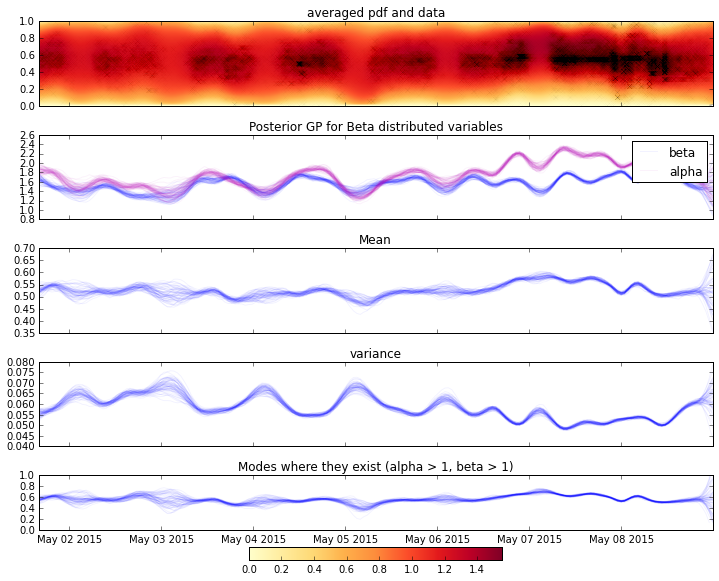

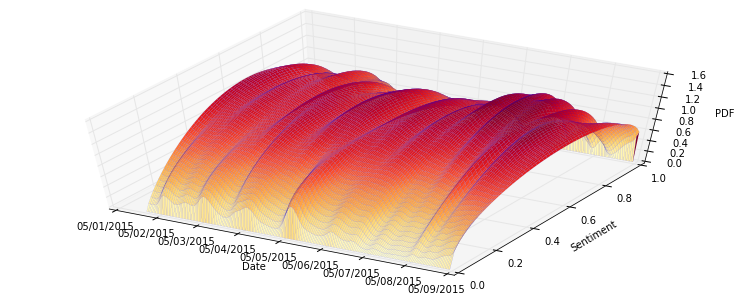

In [23]:
m.plot_fs1(X_scale=X_scale, X_offset=X_offset, y_alpha=0.01)

In [24]:
m

SVGPBeta.,value,constraints,priors
inducing inputs,"(100, 1)",fixed,
q_u_means,"(100, 2)",,
qf_u_chols,"(5050, 2)",,
kernf.kernf_rbf1.variance,1.10274194567,+ve,
kernf.kernf_rbf1.lengthscale,0.261312903976,+ve,
kernf.f_white.variance,9.72968576835e-06,+ve,
kerng.kerng_rbf1.variance,1.10304315474,+ve,
kerng.kerng_rbf1.lengthscale,0.261212932144,+ve,
kerng.g_white.variance,9.72146075934e-06,+ve,


The figures we save for the final paper are a little more complicated

In [25]:
import seaborn as sns
palette = sns.color_palette()

In [26]:
palette[0]

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

In [27]:
def rgb2hex(rgb):
    def clamp(x): 
        return max(0, min(int(x), 255))
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(rgb[0]), clamp(rgb[1]), clamp(rgb[2]))

In [28]:
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'figure.autolayout': True})

def save_plot_fs(self, dim=0, variances=False, median=True, true_variance=True,
                y_alpha=0.3, cmap=plt.cm.YlOrRd, num_pred_points=200,
                X_scale=1.0, X_offset=0.0, plot_dates=True, subsample=1.0):
    """
    Plotting for models with two latent functions, one is an exponent over the scale
    parameter
    """
    import seaborn as sns
    #sns.set_style(style='white')
    #palette = sns.color_palette("hls")
    assert self.likelihood.request_num_latent_functions(self.Y) == 2
    subsample = float(subsample)
    if median:
        XX = fixed_inputs(self, non_fixed_inputs=[dim], fix_routine='median', as_list=False, X_all=True)
    else:
        XX = fixed_inputs(self, non_fixed_inputs=[dim], fix_routine='mean', as_list=False, X_all=True)
    #Now we have the other values fixed, remake the matrix to be the right shape
    XX = np.zeros((num_pred_points, self.X_all.shape[1]))
    for d in range(self.X_all.shape[1]):
        XX[:, d] = self.X_all[0, d]
    X_pred_points = XX.copy()
    X_pred_points_lin = np.linspace(self.X_all[:, dim].min(), self.X_all[:, dim].max(), XX.shape[0])
    X_pred_points[:, dim] = X_pred_points_lin

    mf, covf = self._raw_predict(X_pred_points, 0, full_cov=True)
    mg, covg = self._raw_predict(X_pred_points, 1, full_cov=True)

    covf = covf[:,:,0]
    covg = covg[:,:,0]

    num_samples = 30
    samples_f = np.random.multivariate_normal(mf.flatten(), covf, num_samples)
    samples_g = np.random.multivariate_normal(mg.flatten(), covg, num_samples)

    alpha = np.exp(samples_f)
    beta = np.exp(samples_g)

    num_y_pixels = 40
    #Want the top left pixel to be evaluated at 1
    line = np.linspace(1, 0, num_y_pixels)
    res = np.zeros((X_pred_points.shape[0], num_y_pixels))
    for j in range(X_pred_points.shape[0]):
        sf = alpha[:, j]  # Pick out the jth point along X axis
        sg = beta[:, j]
        for i in range(num_samples):
            # Pick out the sample and evaluate the pdf on a line between 0
            # and 1 with these alpha and beta values
            res[j, :] += beta_dist.pdf(line, sf[i], sg[i])
        res[j, :] /= num_samples

    vmax, vmin = res[np.isfinite(res)].max(), res[np.isfinite(res)].min()
    

    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
    
    X_all = self.X_all*X_scale + X_offset
    X_pred_points = X_pred_points*X_scale + X_offset
    fig_data, ax1 = plt.subplots(1)
    fig_latents, ax2 = plt.subplots(1)
    fig_mean, ax3 = plt.subplots(1)
    fig_var, ax4 = plt.subplots(1)
    fig_modes, ax5 = plt.subplots(1)
    fig_mean_var, ax6 = plt.subplots(1)
    fig3d = plt.figure(figsize=(8,4))
    
    fig_data.set_figwidth(12)
    fig_data.set_figheight(2)
    fig_latents.set_figwidth(5)
    fig_latents.set_figheight(2)
    fig_mean.set_figwidth(5)
    fig_mean.set_figheight(2)
    fig_var.set_figwidth(5)
    fig_var.set_figheight(2)
    fig_modes.set_figwidth(5)
    fig_modes.set_figheight(2)
    fig_mean_var.set_figwidth(5)
    fig_mean_var.set_figheight(2)
    
    #ax1.set_title('Beta PDF')
    im = ax1.imshow(res.T, origin='upper', 
                    extent=[X_pred_points[:,dim].min(),X_pred_points[:,dim].max(), 0, 1],
                    aspect='auto', cmap=cmap, norm=norm)
    fig.colorbar(im, orientation='horizontal', pad=0.2)
    #Subsample and change y_alpha accordingly
    subsample_inds = np.random.permutation(range(X_all.shape[0]))[:int(X_all.shape[0]*subsample)]
    X_sub = X_all[subsample_inds, :]
    Y_sub = self.Y_all[subsample_inds, :]
    y_alpha = y_alpha/float(subsample)
    if plot_dates:
        #All others should follow suit since we sharex
        ax1.plot_date(X_sub, Y_sub, 'kx', alpha=y_alpha)
    else:
        ax1.plot(X_sub, Y_sub, 'kx', alpha=y_alpha)
    ax1.set_ylabel('Sentiment')
    
    #For labels
    ax2.set_title(r'Posterior GP for latent functions of $\textrm{Beta}(\alpha,\beta)$')
    ax2.plot(X_pred_points, beta.T[:,0], 'b-', label=r'$\beta$', alpha=3./num_samples)
    ax2.plot(X_pred_points, alpha.T[:,0], 'm-', label=r'$\alpha$', alpha=3./num_samples)
    
    #For rest of samples
    ax2.plot(X_pred_points, beta.T[:,1:], 'b-', alpha=3./num_samples)
    ax2.plot(X_pred_points, alpha.T[:,1:], 'm-', alpha=3./num_samples)

    
    ax3.plot(X_pred_points, alpha.T / (alpha.T + beta.T), 'b-', alpha=3./num_samples)
    ax3.set_title('Mean')

    var = (alpha.T*beta.T) / ((alpha.T + beta.T)**2 * (alpha.T+beta.T +1))
    ax4.plot(X_pred_points, var, 'b-', alpha=3./num_samples)
    ax4.set_title('Variance')

    for i in range(num_samples):
        a = alpha[i, :]
        b = beta[i, :]
        mode = (a - 1) / (a + b - 2)
        mode = np.where(mode < 0, np.nan, mode)
        ax5.plot(X_pred_points, mode, 'b-', alpha=3./num_samples)
    ax5.set_title(r'Modes where they exist ($\alpha > 1$, $\beta > 1$)', fontsize=10)
    ax5.set_ylim(0,1)


    ax = fig3d.add_subplot(111, projection='3d')
    ax.view_init(elev=55., azim=300.0)
    axlim_min, axlim_max = X_pred_points[:, dim].min(), X_pred_points[:, dim].max()
    x, y = np.mgrid[axlim_min:axlim_max:complex(res.shape[0]),
                    1:0:complex(res.shape[1])]
    #x_dates = num2date(x)
    xfmt = mdates.DateFormatter('%b %d')
    xfmt = mdates.DateFormatter('%m/%d/%y')
    p = ax.plot_surface(x,y,res,cmap=cmap,rstride=1, cstride=1, lw=0.01, alpha=1, edgecolor='b', norm=norm)
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set_zlabel('PDF')
    ax.set_ylabel('Sentiment')

    #plt.colorbar(p, orientation='vertical', pad=0.1)
    
    #Twin plot the mean and variance
    ax6.plot(X_pred_points, alpha.T / (alpha.T + beta.T), 'b-', alpha=3./num_samples)
    for tl in ax6.get_yticklabels():
        tl.set_color('b')
    ax6.set_ylabel('Mean', color='b')
    ax6.set_title('Mean and Variance of Beta($\alpha$, $\beta$)')
    
    ax7 = ax6.twinx()
    var = (alpha.T*beta.T) / ((alpha.T + beta.T)**2 * (alpha.T+beta.T +1))
    ax7.plot(X_pred_points, var, 'm-', alpha=3./num_samples)
    for tl in ax7.get_yticklabels():
        tl.set_color('m')
    ax7.set_ylabel('Variance', color='m')
    ax6.grid(True)
    
    ax2.legend(loc='lower right', bbox_to_anchor=(1.15, 0.7))
    ax1.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax2.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax3.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax4.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax5.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax6.set_xlim(X_pred_points[:, dim].min(), X_pred_points[:, dim].max())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax4.xaxis.set_major_locator(mdates.DayLocator())
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax5.xaxis.set_major_locator(mdates.DayLocator())
    ax6.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax6.xaxis.set_major_locator(mdates.DayLocator())
    ax2.locator_params(axis='y', nbins=5)
    ax3.locator_params(axis='y', nbins=5)
    ax4.locator_params(axis='y', nbins=5)
    ax5.locator_params(axis='y', nbins=5)
    ax6.locator_params(axis='y', nbins=5)
    ax7.locator_params(axis='y', nbins=4)
    ax.locator_params(axis='z', nbins=5)
    #Makes me want to cry a little bit inside.
    ax.zaxis._axinfo['label']['space_factor'] = 2.0
    ax.yaxis._axinfo['label']['space_factor'] = 2.0
    #fig_data.autofmt_xdate()
    fig_latents.autofmt_xdate()
    fig_mean.autofmt_xdate()
    fig_var.autofmt_xdate()
    fig_modes.autofmt_xdate()
    fig_mean_var.autofmt_xdate()
    fig3d.autofmt_xdate()
    fig3d.tight_layout()
    ax.autoscale(tight=True)
    return fig_data, fig_latents, fig_mean, fig_var, fig_modes, fig3d, fig_mean_var

from functools import partial
m.save_plot_fs = partial(save_plot_fs, m)

(<matplotlib.figure.Figure at 0x7fc3918597d0>,
 <matplotlib.figure.Figure at 0x7fc3916fd0d0>)

 /home/alans/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


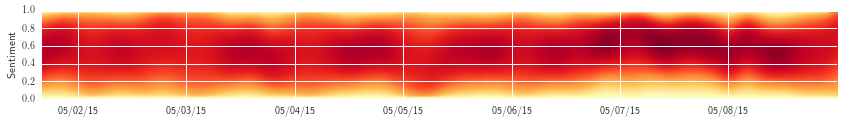

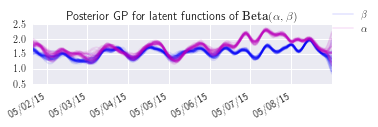

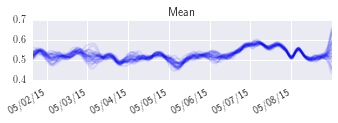

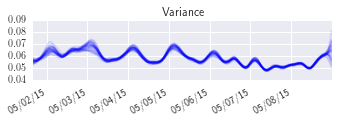

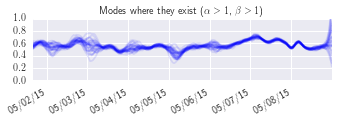

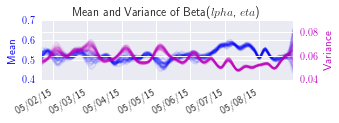

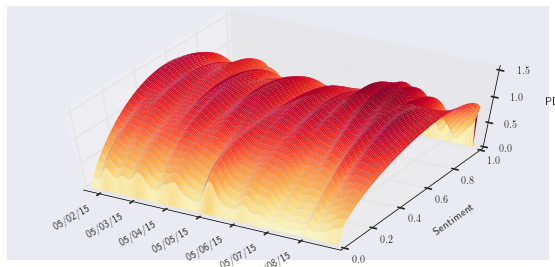

In [29]:
m.save_plot_fs(X_scale=X_scale, X_offset=X_offset, y_alpha=0.01, subsample=0.1)
#fig_data, fig_latents, fig_mean, fig_var, fig_modes, fig3d = m.save_plot_fs(X_scale=X_scale, X_offset=X_offset, y_alpha=0.01, subsample=0.1)

In [30]:
save = False
if save:
    #Save all formats
    fig_data.savefig('labour_pdf.eps', rasterized=True, dpi=100, bbox_inches='tight')
    fig_data.savefig('labour_pdf.pdf', rasterized=True, dpi=100, bbox_inches='tight')

    fig3d.savefig('labour_3d.eps', rasterized=True, dpi=100, bbox_inches='tight', pad_inches=1.0)
    fig3d.savefig('labour_3d.pdf', rasterized=True, dpi=100, bbox_inches='tight', pad_inches=1.0)

    fig_latents.savefig('labour_latent.eps', rasterized=True, dpi=100, bbox_inches='tight')
    fig_latents.savefig('labour_latent.pdf', rasterized=True, dpi=100, bbox_inches='tight')

    tikz_save('labour_latent.tikz', fig_latents)
    tikz_save('labour_mean.tikz', fig_mean)
    tikz_save('labour_var.tikz', fig_var)
    tikz_save('labour_modes.tikz', fig_modes)
    tikz_save('labour_mean_vars.tikz', fig_mean_vars)
    #tikz_save('labour_pdf.tikz', fig_data)
    #tikz_save('labour_3d.tikz', fig3d)

In [31]:
m

SVGPBeta.,value,constraints,priors
inducing inputs,"(100, 1)",fixed,
q_u_means,"(100, 2)",,
qf_u_chols,"(5050, 2)",,
kernf.kernf_rbf1.variance,1.10274194567,+ve,
kernf.kernf_rbf1.lengthscale,0.261312903976,+ve,
kernf.f_white.variance,9.72968576835e-06,+ve,
kerng.kerng_rbf1.variance,1.10304315474,+ve,
kerng.kerng_rbf1.lengthscale,0.261212932144,+ve,
kerng.g_white.variance,9.72146075934e-06,+ve,
